In [164]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

In [165]:
EMPRESA = 'WEGE3.SA'

## Funções

In [166]:
def dias_uteis_entre_datas(start_date,end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')

    date_list = date_range.strftime('%Y-%m-%d').tolist()

    return date_list


In [167]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [168]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [169]:
def adiciona_nova_linha(df, novo_fechamento, data):
    new_row = {
            'Close': novo_fechamento,
            'prev-day-1': df.iloc[-1]['Close'] if len(df) >= 1 else None,
            'prev-day-2': df.iloc[-2]['Close'] if len(df) >= 2 else None,
            'prev-day-3': df.iloc[-3]['Close'] if len(df) >= 3 else None
        }

    new_index = pd.to_datetime(data)
    new_df = pd.DataFrame(new_row, index=[new_index])
    df = pd.concat([df, new_df])
    df['mm_5'] = df['Close'].rolling(5).mean()
    df['mm_21'] = df['Close'].rolling(21).mean()
    return df

In [170]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [171]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))

In [172]:
def predict_next_day(df,model):
    ultimo_registro = df.tail(1)
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(ultimo_registro)
    return model.predict(np.array([X_tomorrow[-1]]))

## Pré-processamento

In [173]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

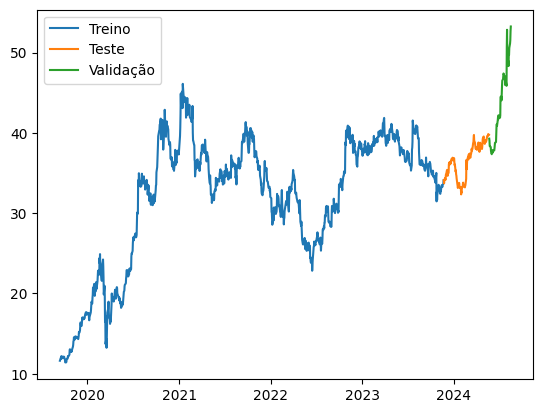

In [174]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## LSTM

Resultado com dados nunca vistos pelo modelo

In [175]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1024.7775 - mean_absolute_error: 30.9174 - val_loss: 948.6239 - val_mean_absolute_error: 30.7160
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 553.0368 - mean_absolute_error: 21.4532 - val_loss: 24.7584 - val_mean_absolute_error: 4.4493
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 65.8351 - mean_absolute_error: 6.2305 - val_loss: 19.1970 - val_mean_absolute_error: 3.9651
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.0144 - mean_absolute_error: 3.7646 - val_loss: 1.1789 - val_mean_absolute_error: 0.9229
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7726 - mean_absolute_error: 1.2580 - val_loss: 0.6056 - val_mean_absolute_error: 0.5941
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8146 - mean_absolute_error: 1.0099 - val_loss: 1.2096 - val_mean_absolute_error: 0.8966
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0586 - mean_absolute_error: 1.

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


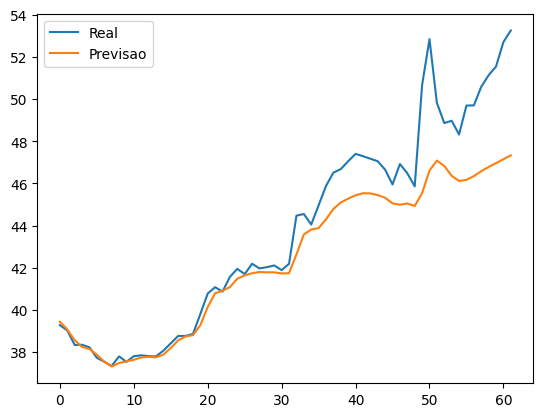

In [176]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## FeedForward

In [177]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 56.8744 - mean_absolute_error: 5.8484 - val_loss: 0.6201 - val_mean_absolute_error: 0.6269
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1507 - mean_absolute_error: 1.1299 - val_loss: 0.6343 - val_mean_absolute_error: 0.6203
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4728 - mean_absolute_error: 0.9071 - val_loss: 0.5630 - val_mean_absolute_error: 0.5919
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4349 - mean_absolute_error: 0.8905 - val_loss: 0.5153 - val_mean_absolute_error: 0.5576
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4583 - mean_absolute_error: 0.8720 - val_loss: 0.5118 - val_mean_absolute_error: 0.5610
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3685 - mean_absolute_error: 0.8502 - val_loss: 0.5742 - val_mean_absolute_error: 0.6025
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5191 - mean_absolute_error: 0.9089 - val_loss: 0.5423 -

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


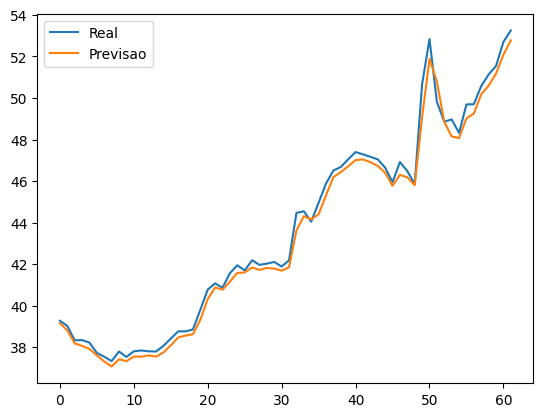

In [178]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## RNN

In [179]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 994.2692 - mean_absolute_error: 30.4153 - val_loss: 951.7554 - val_mean_absolute_error: 30.7747
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 719.9162 - mean_absolute_error: 25.5859 - val_loss: 825.3005 - val_mean_absolute_error: 28.6466
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 638.3723 - mean_absolute_error: 23.8928 - val_loss: 738.2183 - val_mean_absolute_error: 27.0841
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 553.8195 - mean_absolute_error: 22.1129 - val_loss: 664.7589 - val_mean_absolute_error: 25.6922
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 492.2082 - mean_absolute_error: 20.6645 - val_loss: 599.2253 - val_mean_absolute_error: 24.3835
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 442.7394 - mean_absolute_error: 19.4650 - val_loss: 540.5093 - val_mean_absolute_error: 23.1482
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 407.1398 -

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


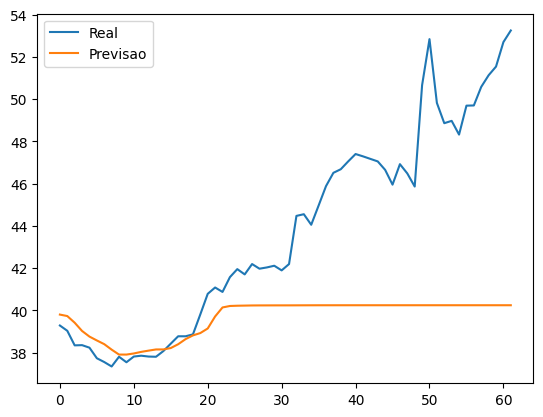

In [180]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## CNN

In [181]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 807.0817 - mean_absolute_error: 24.8301 - val_loss: 22.6630 - val_mean_absolute_error: 4.7109
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 13.7507 - mean_absolute_error: 3.1739 - val_loss: 2.3391 - val_mean_absolute_error: 1.3950
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5202 - mean_absolute_error: 0.9259 - val_loss: 0.4576 - val_mean_absolute_error: 0.5372
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3866 - mean_absolute_error: 0.8422 - val_loss: 0.4511 - val_mean_absolute_error: 0.5324
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1128 - mean_absolute_error: 0.7747 - val_loss: 0.5149 - val_mean_absolute_error: 0.5742
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2574 - mean_absolute_error: 0.8019 - val_loss: 0.5002 - val_mean_absolute_error: 0.5655
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2201 - mean_absolute_error: 0.7856 - val_loss: 0.

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


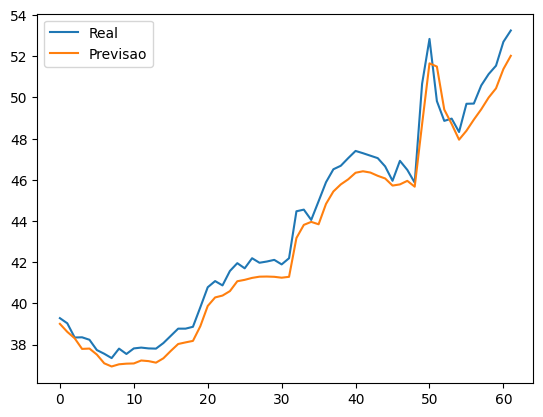

In [182]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

In [188]:
df_teste = df.copy()

dias_uteis = dias_uteis_entre_datas('2024-08-16', '2024-09-16')

for dia in dias_uteis:
    proxima_predicao = float(predict_next_day(df_teste, model_feedforward)[-1])
    df_teste.iloc[-1, df.columns.get_loc('tomorrow')] = proxima_predicao
    df_teste = adiciona_nova_linha(df_teste, proxima_predicao, dia)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


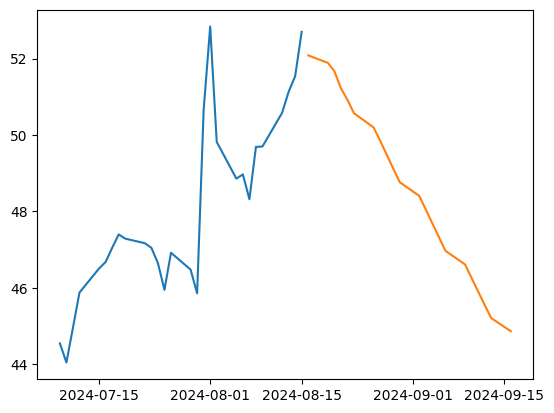

In [189]:
plt.plot(df_teste[-50:-22]['Close'])
plt.plot(df_teste[-22:]['Close'])

In [185]:
df_teste

,Close,prev-day-1,prev-day-2,prev-day-3,mm_5,mm_21,tomorrow
2019-09-13,11.860000,11.525000,11.540000,11.465000,NaN,NaN,11.620000
2019-09-16,11.620000,11.860000,11.525000,11.540000,NaN,NaN,11.900000
2019-09-17,11.900000,11.620000,11.860000,11.525000,NaN,NaN,12.000000
2019-09-18,12.000000,11.900000,11.620000,11.860000,NaN,NaN,11.845000
2019-09-19,11.845000,12.000000,11.900000,11.620000,11.845000,NaN,12.200000
...,...,...,...,...,...,...,...
2024-09-10,43.935760,44.354664,44.794437,45.219437,44.794923,48.306997,43.506718
2024-09-11,43.506718,43.935760,44.354664,44.794437,44.362203,47.943984,43.095867
2024-09-12,43.095867,43.506718,43.935760,44.354664,43.937489,47.541882,42.678112
2024-09-13,42.678112,43.095867,43.506718,43.935760,43.514224,47.064649,42.277023
